In [1]:
import numpy as np
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
import time, datetime
%load_ext autoreload
%autoreload 1
%aimport environmental_density
from environmental_density import get_density_periodic
np.random.seed(999)

In [53]:
#galfile = pd.read_hdf('/scratch/data/galcats/P200/galaxies.Z01.h5')
galfile = pd.read_hdf('test_galcat.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()
print(gal_header)

### Remove data points with halo mass below 10.5
print(np.shape(galaxies))
galaxies = galaxies[galaxies[:,6] > 10.5, :]
print(np.shape(galaxies))

['X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'Halo_mass', 'Stellar_mass', 'SFR', 'Intra_cluster_mass', 'Halo_mass_peak', 'Stellar_mass_obs', 'SFR_obs', 'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM', 'Type']
(20000, 20)
(10337, 20)


In [3]:
data_dict = {'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 'Z_vel': 5, 'Halo_mass': 6, 
             'Stellar_mass': 7, 'SFR': 8, 'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 'Stellar_mass_obs': 11, 
             'SFR_obs': 12, 'Halo_radius': 13, 'Concentration': 14, 'Halo_spin': 15, 'Scale_peak_mass': 16, 
             'Scale_half_mass': 17, 'Scale_last_MajM': 18, 'Type': 19}

In [4]:
### Make sure that the edges are what they should be
print(np.min(galaxies[:, 0]), np.max(galaxies[:, 0]))
print(np.min(galaxies[:, 1]), np.max(galaxies[:, 1]))
print(np.min(galaxies[:, 2]), np.max(galaxies[:, 2]))

0.0021691015 199.99994
0.0025675078 199.94019
0.040371846 199.98619


In [54]:
coordinates = galaxies[:, :3]
halo_masses = np.power(10, galaxies[:, 6])
nr_points = np.shape(coordinates)[0]

In [67]:
nr_neighbours_wanted = 500
box_sides = np.array([200, 200, 200])

neigh_densities, neigh_indices, neigh_masses = get_density_periodic(coordinates, halo_masses, nr_neighbours_wanted, 
                                        box_sides, nr_points, verbatim=True, progress_file=True, get_neighbours=True)
neigh_densities = np.log10(neigh_densities)

16:10:53      Time elapsed: 0.01min. Time remaining: 0.11min.
16:10:54      Time elapsed: 0.02min. Time remaining: 0.10min.
16:10:55      Time elapsed: 0.04min. Time remaining: 0.09min.
16:10:55      Time elapsed: 0.05min. Time remaining: 0.08min.
16:10:56      Time elapsed: 0.06min. Time remaining: 0.06min.
16:10:57      Time elapsed: 0.07min. Time remaining: 0.05min.
16:10:58      Time elapsed: 0.08min. Time remaining: 0.04min.
16:10:58      Time elapsed: 0.09min. Time remaining: 0.03min.
16:10:59      Time elapsed: 0.11min. Time remaining: 0.02min.
16:11:00      Time elapsed: 0.12min. Time remaining: 0.00min.


In [7]:
print(np.mean(neigh_densities))
print(np.sum(halo_masses)/200**3)

8.493764103208843
326650583.580672


In [56]:
print(neigh_indices[3])

[4222 2171 3618    3 7880 7197 6374  534 8334 3230 1284]


## Plot the data points to make sure that the correct neighbors were chosen

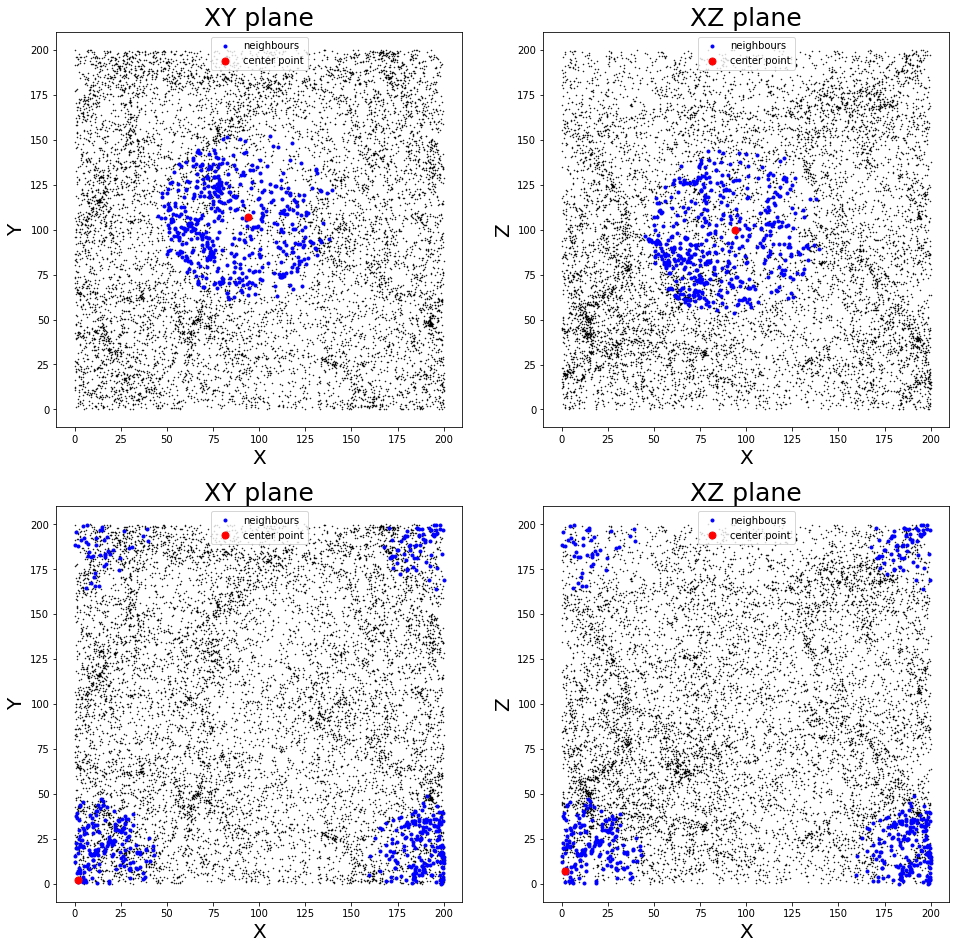

In [69]:
not_found_middle = True
not_found_corner = True
point_counter = 0
while not_found_middle or not_found_corner:
    
    if not_found_corner:
        
        is_in_corner = (coordinates[point_counter,0] < 10 and coordinates[point_counter,1] < 10 and 
                     coordinates[point_counter,2] < 10)
        if is_in_corner:
            not_found_corner = False
            corner_point = point_counter
            
    if not_found_middle:
        is_in_middle = (coordinates[point_counter,0] < 110 and coordinates[point_counter,1] < 110 and 
                        coordinates[point_counter,2] < 110 and coordinates[point_counter,0] > 90 and 
                        coordinates[point_counter,1] > 90 and coordinates[point_counter,2] > 90)
        if is_in_middle:
            not_found_middle = False
            middle_point = point_counter
    point_counter += 1

fig = plt.figure(5, figsize=(16,16))
ax = plt.subplot(221)

ax.plot(coordinates[:,0], coordinates[:,1], 'k.', markersize=1)
neigh_points = ax.plot(coordinates[neigh_indices[middle_point],0], 
                       coordinates[neigh_indices[middle_point],1], 'bo', markersize=3, label='neighbours')
mid_point = ax.plot(coordinates[middle_point,0], coordinates[middle_point,1], 'ro', markersize=7, label='center point')
plt.title('XY plane', fontsize=25)
plt.ylabel('Y', fontsize=20)
plt.xlabel('X', fontsize=20)
ax.legend(loc='upper center')

ax = plt.subplot(222)
ax.plot(coordinates[:,0], coordinates[:,2], 'k.', markersize=1)
neigh_points = ax.plot(coordinates[neigh_indices[middle_point],0], 
                       coordinates[neigh_indices[middle_point],2], 'bo', markersize=3, label='neighbours')
mid_point = ax.plot(coordinates[middle_point,0], coordinates[middle_point,2], 'ro', markersize=7, label='center point')
plt.title('XZ plane', fontsize=25)
plt.ylabel('Z', fontsize=20)
plt.xlabel('X', fontsize=20)
ax.legend(loc='upper center')

#plt.show()

#fig = plt.figure(5, figsize=(16,8))
ax = plt.subplot(223)

ax.plot(coordinates[:,0], coordinates[:,1], 'k.', markersize=1)
ax.plot(coordinates[neigh_indices[corner_point],0], 
                       coordinates[neigh_indices[corner_point],2], 'bo', markersize=3, label='neighbours')
ax.plot(coordinates[corner_point,0], coordinates[corner_point,1], 'ro', markersize=7, label='center point')
plt.title('XY plane', fontsize=25)
plt.ylabel('Y', fontsize=20)
plt.xlabel('X', fontsize=20)
ax.legend(loc='upper center')

ax = plt.subplot(224)
ax.plot(coordinates[:,0], coordinates[:,2], 'k.', markersize=1)
neigh_points = ax.plot(coordinates[neigh_indices[corner_point],0], 
                       coordinates[neigh_indices[corner_point],2], 'bo', markersize=3, label='neighbours')
ax.plot(coordinates[corner_point,0], coordinates[corner_point,2], 'ro', markersize=7, label='center point')
plt.title('XZ plane', fontsize=25)
plt.ylabel('Z', fontsize=20)
plt.xlabel('X', fontsize=20)
ax.legend(loc='upper center')

plt.show()

In [70]:
### Save the figure
fig.savefig('neighbours_visualisation.png', bbox_inches = 'tight')

## Make a new pd dataset and save it

In [8]:
pd_dataframe = pd.DataFrame(data=galaxies, columns=gal_header)
pd_dataframe['Environmental_density'] = neigh_densities

In [9]:
pd_dataframe.to_hdf('test_galcat_w_log_densities_3e5.h5', 'w')

## Try loading the newly created galaxy catalogue

In [10]:
galfile = pd.read_hdf('test_galcat_w_log_densities_3e5.h5')
galaxies = galfile.as_matrix()
gal_header = galfile.keys().tolist()
print(gal_header)
print(np.shape(galaxies))

['X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'Halo_mass', 'Stellar_mass', 'SFR', 'Intra_cluster_mass', 'Halo_mass_peak', 'Stellar_mass_obs', 'SFR_obs', 'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM', 'Type', 'Environmental_density']
(306925, 21)


In [11]:
print('%.2f' % (np.mean(galaxies[:,20])))
print('%.2f' % (np.amax(galaxies[:,20])))
print('%.2f' % (np.amin(galaxies[:,20])))
#print(np.sum(galaxies[:,6]) / 200**3)

10.90
17.92
8.15


In [ ]:
galaxies[:,20] = np.log10(galaxies[:,20])

## Old functions

In [ ]:
@jit(nopython=True)
def nearest_k_neighbours_1(coordinates, nr_neighbours, box_sides, nr_points):
    indices_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours))
    for i in range(nr_points):

        euclidean_dists = np.sqrt(np.sum(np.minimum(np.abs(coordinates - coordinates[i,:]), box_sides - 
                                                    (np.abs(coordinates - coordinates[i,:])))**2, 1))
        indices_of_neighbors[i,:] = np.argsort(euclidean_dists)[:nr_neighbours]
    
    return indices_of_neighbors

In [ ]:
@jit(nopython=True)
def nearest_k_neighbours_2(coordinates, nr_neighbours, box_sides, nr_points):
    indices_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours))
#    weights_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours))
    for i in range(nr_points):
        norm_dist = np.abs(coordinates - coordinates[i,:])
        inv_dist = box_sides - norm_dist
        shortest_dists = np.minimum(norm_dist, inv_dist)
        squared_shortest_dists = shortest_dists**2
        summed_squared_shortest_dists = np.sum(squared_shortest_dists, 1)
        euclidean_dists = np.sqrt(summed_squared_shortest_dists)
        
        indices_of_neighbors[i,:] = np.argsort(euclidean_dists)[:nr_neighbours]
#        weights_of_neighbors[i,:]
    
    return indices_of_neighbors

In [ ]:
def nearest_k_neighbours_3(coordinates, nr_neighbours, box_sides, nr_points):
    indices_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours))
    for i in range(nr_points):

        euclidean_dists = np.sqrt(np.sum(np.minimum(np.abs(coordinates - coordinates[i,:]), box_sides - 
                                                    (np.abs(coordinates - coordinates[i,:])))**2, 1))
        indices_of_neighbors[i,:] = np.argpartition(euclidean_dists, nr_neighbours)[:nr_neighbours]
    
    return indices_of_neighbors

In [ ]:
@jit
def get_density_periodic_jit(coordinates, weights, nr_neighbours, box_sides, nr_points):
    indices_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours), dtype=np.int8)
    masses_of_neighbors = np.zeros((coordinates.shape[0], nr_neighbours))
    neigh_densities = np.zeros(nr_points)
    for i in range(nr_points):
        norm_dist = np.abs(coordinates - coordinates[i,:])
        inv_dist = box_sides - norm_dist
        shortest_dists = np.minimum(norm_dist, inv_dist)
        squared_shortest_dists = shortest_dists**2
        summed_squared_shortest_dists = np.sum(squared_shortest_dists, 1)
        euclidean_dists = np.sqrt(summed_squared_shortest_dists)
        
        indices_of_k_closest_neighbours = np.argpartition(euclidean_dists, nr_neighbours)[:nr_neighbours]
        indices_of_neighbors[i,:] = indices_of_k_closest_neighbours
        masses_of_neighbors[i,:] = weights[indices_of_k_closest_neighbours]
        
        sphere_radius = np.max(euclidean_dists[indices_of_k_closest_neighbours])
        print('sphere radius: ', sphere_radius)
        sphere_volume = (4/3) * math.pi * sphere_radius**3
#        print('sphere volume: ', sphere_volume)
        density =  np.sum(masses_of_neighbors[i,:]) / sphere_volume
#        print('density: ', density)
        neigh_densities[i] = density
    
    return indices_of_neighbors, masses_of_neighbors, neigh_densities
                

In [ ]:
#@jit
def get_density_periodic_OLD(coordinates, weights, nr_neighbours, box_sides, nr_points, verbatim=False):
    
    with open('results.txt', 'w+') as f:

        neigh_densities = np.zeros(nr_points)

        start = time.time()
        for i in range(nr_points):

            if int(i/1000) == i/1000 and i > 0:
                end = time.time()
                elapsed_time = (end-start)/60
                time_remaining = elapsed_time / i * (nr_points - i)
                if verbatim:
                    print('%s      Time elapsed: %.2fmin. Time remaining: %.2fmin.' % (datetime.datetime.now().strftime("%H:%M:%S"),
                                                                            elapsed_time, time_remaining))
                f.write('%s      Time elapsed: %.2fmin. Time remaining: %.2fmin.\n' % (datetime.datetime.now().strftime("%H:%M:%S"),
                                                                        elapsed_time, time_remaining))
                f.flush()
            norm_dist = np.abs(coordinates - coordinates[i,:])
            inv_dist = box_sides - norm_dist
            shortest_dists = np.minimum(norm_dist, inv_dist)
            squared_shortest_dists = shortest_dists**2
            summed_squared_shortest_dists = np.sum(squared_shortest_dists, 1)
            euclidean_dists = np.sqrt(summed_squared_shortest_dists)

            indices_of_k_closest_neighbours = np.argpartition(euclidean_dists, nr_neighbours)[:nr_neighbours]
            masses_of_k_closest_neighbours = weights[indices_of_k_closest_neighbours]

            sphere_radius = np.amax(euclidean_dists[indices_of_k_closest_neighbours])

            if sphere_radius > box_sides[0]/2:
                print('WARNING! Sphere with radius larger than %d mega parsecs created.' % (box_sides[0]/2))
                f.write('WARNING! Sphere with radius larger than %d mega parsecs created.\n' % (box_sides[0]/2))
                f.flush()
            sphere_volume = (4/3) * math.pi * sphere_radius**3
            density =  np.sum(masses_of_k_closest_neighbours) / sphere_volume
            neigh_densities[i] = density
            
        elapsed_time = (end-start)/60
        time_remaining = elapsed_time / i * (nr_points - i)
        f.write('%s      Script finished. Elapsed time: %.2fmin.' % (datetime.datetime.now().strftime("%H:%M:%S"), elapsed_time))
    
    return neigh_densities